In [1]:
%env MUJOCO_GL=egl

env: MUJOCO_GL=egl


In [2]:
import uitb
assert "user-in-the-box-private/" in uitb.__file__

In [3]:
from uitb.simulator import Simulator

import numpy as np
import os, re, glob
import logging

In [4]:
# import time

# import mujoco
# import mujoco.viewer

# m = mujoco.MjModel.from_xml_path('/home/florian/uitb-sim2vr/user-in-the-box-private/trained/unity_hard_pretrained/unity_hard_pretrained/simulation.xml')
# d = mujoco.MjData(m)

# with mujoco.viewer.launch_passive(m, d) as viewer:
#   # Close the viewer automatically after 30 wall-seconds.
#   start = time.time()
#   while viewer.is_running() and time.time() - start < 30:
#     step_start = time.time()

#     # mj_step can be replaced with code that also evaluates
#     # a policy and applies a control signal before stepping the physics.
#     mujoco.mj_step(m, d)

#     # Example modification of a viewer option: toggle contact points every two seconds.
#     with viewer.lock():
#       viewer.opt.flags[mujoco.mjtVisFlag.mjVIS_CONTACTPOINT] = int(d.time % 2)

#     # Pick up changes to the physics state, apply perturbations, update options from GUI.
#     viewer.sync()

#     # Rudimentary time keeping, will drift relative to wall clock.
#     time_until_next_step = m.opt.timestep - (time.time() - step_start)
#     if time_until_next_step > 0:
#       time.sleep(time_until_next_step)

In [5]:
from stable_baselines3 import PPO

class EvaluationLogs(object):
    def __init__(self, env, log_variables: dict[str, tuple[str]]):
        #stores references to env variables in self._objects, which are evaluated and copied to self._logs when self.log() is called
        self._env = env
        self._log_variables = log_variables

        self._logs = {}
        self.log_counter = 0
        
    def log(self, use_timestamps=True, id=None):
        # Collect logs
        _new_log = {}
        for log_name, log_var in self._log_variables.items():
            _object = self._env
            for _key in log_var:
                _object = getattr(_object, _key)
            if hasattr(_object, "copy"):
                _new_log[log_name] = _object.copy()
            else:
                _new_log[log_name] = _object
        
        # Get index
        if id is not None:
            _idx = id
        elif use_timestamps:
            if hasattr(env, "_data") and hasattr(env._data, "time"):
                _idx = env._data.time
            else:
                logging.warning("Could not read time from env._data object. Will use integer indices instead.")
        else:
            _idx = self.log_counter
        
        # Store logs
        self._logs[_idx] = _new_log
        self.log_counter += 1
        
    def get_logs(self, variable=None, indices=None):
        if variable is not None:
            assert variable in self._log_variables, f"Invalid variable '{variable}'. Valid variables are {self._log_variables.keys()}."
            if indices is not None:
                return {k: v[variable][indices] for k, v in self._logs.items()}
            else:
                return {k: v[variable] for k, v in self._logs.items()}
        else:
            return self._logs
    

In [6]:
REMOTE_DISPLAY = True

if REMOTE_DISPLAY:
    process = os.popen("hostname --ip-address")
    _myipaddress = process.read().split()[0]
    process.close()

    # os.environ["DISPLAY"] = f"{_myipaddress}:1"  #run remotely (X server needs to be configured to accept remote connections, see https://askubuntu.com/a/34663)
    os.environ["DISPLAY"] = f":1"  #run remotely (X server needs to be configured to accept remote connections, see https://askubuntu.com/a/34663)

    process = os.popen("echo /run/user/$(id -u)")
    _pam = process.read().split("\n")[0]
    process.close()

    os.environ["XDG_RUNTIME_DIR"] = _pam
else:
    # use X11 forwarding (e.g., using MobaXterm)
    os.environ["DISPLAY"] = "localhost:10.0"  #forward to localhost:10.0

In [7]:
# Graphics-related imports
import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt
from IPython.display import HTML
import PIL.Image, PIL.ImageDraw, PIL.ImageFont
# Internal loading of video libraries.

# Use svg backend for figure rendering
%config InlineBackend.figure_format = 'svg'

In [8]:
def natural_sort(l):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)]
    return sorted(l, key=alphanum_key)

In [9]:
def get_logdir(filepath):
    """Get latest subdir in logging filepath that was created by Unity App."""
    
    filepath = os.path.expanduser(filepath)
    
    subdirs = natural_sort(os.listdir(filepath))
    
    # only consider directories that contain a non-empty states.csv file, excluding hidden directories (e.g. '.ipynb_checkpoints')
    subdirs = [i for i in subdirs if os.path.isdir(os.path.join(os.path.expanduser(filepath), i)) and ((not os.path.isfile(os.path.join(os.path.expanduser(filepath), i, "states.csv"))) or (os.path.getsize(os.path.join(os.path.expanduser(filepath), i, "states.csv")) > 0)) and (not i.startswith('.')) and (len(os.listdir(os.path.join(filepath, i))) > 0)]
    
    if len(subdirs) > 0:
        last_subdir = subdirs[-1]
        filepath_new = os.path.join(filepath, last_subdir)
        if os.path.isdir(filepath_new):
            return get_logdir(filepath_new)
    
    return filepath

# # copy logged pickles to logging dir
# _SIMULATION_USER_ID = 91  #fake simulation user ID used for testing

# _evaluation_dir = f"~/uitb-sim2vr/user-in-the-box-private/{_TASK_CONDITION}/evaluate/"
# _latest_logdir_condition = get_logdir(os.path.join(_evaluation_dir, "logging"))
# # _latest_logdir = os.path.dirname(os.path.expanduser(_latest_logdir_condition))
# os.popen(f'cp {_evaluation_dir}/*_log.pickle {_latest_logdir_condition}') #copy uitb/MuJoCo logs (pickle files) to recent unity logdir (containing the csv files)
# if len(glob.glob(os.path.expanduser(f'{_evaluation_dir}/*.mp4'))) > 0:
#     os.popen(f'ln -sf {_evaluation_dir}/*.mp4 {_latest_logdir_condition}') #link generated video to recent unity logdir
# os.popen(f'mkdir -p ~/uitb-sim2vr/user-in-the-box-private/datasets/vr-uitb-experiment/{_SIMULATION_USER_ID}/')
# os.popen(f'cp -r {_latest_logdir_condition} ~/uitb-sim2vr/user-in-the-box-private/datasets/vr-uitb-experiment/{_SIMULATION_USER_ID}/') #copy (unity) logdir to datasets

def _copy_to_dataset(TASK_CONDITION, SIMULATION_USER_ID):
    # copy logged pickles to logging dir
    _evaluation_dir = f"~/uitb-sim2vr/user-in-the-box-private/{TASK_CONDITION}/evaluate/"
    _latest_logdir_condition = get_logdir(os.path.join(_evaluation_dir, "logging"))
    # _latest_logdir = os.path.dirname(os.path.expanduser(_latest_logdir_condition))
    os.popen(f'cp {_evaluation_dir}/*_log.pickle {_latest_logdir_condition}') #copy uitb/MuJoCo logs (pickle files) to recent unity logdir (containing the csv files)
    if len(glob.glob(os.path.expanduser(f'{_evaluation_dir}/*.mp4'))) > 0:
        os.popen(f'ln -sf {_evaluation_dir}/*.mp4 {_latest_logdir_condition}') #link generated video to recent unity logdir
    os.popen(f'mkdir -p ~/uitb-sim2vr/user-in-the-box-private/datasets/vr-uitb-experiment/{SIMULATION_USER_ID}/')
    os.popen(f'cp -r {_latest_logdir_condition} ~/uitb-sim2vr/user-in-the-box-private/datasets/vr-uitb-experiment/{SIMULATION_USER_ID}/') #copy (unity) logdir to datasets

    print(f"NEW [{SIMULATION_USER_ID}]: {_latest_logdir_condition} successfully registered at '~/uitb-sim2vr/user-in-the-box-private/datasets/vr-uitb-experiment/{SIMULATION_USER_ID}/'.")

In [10]:
## Custom video functions

def display_video(frames, framerate=30):
    anim = _create_animation(frames, framerate=framerate)
    return HTML(anim.to_html5_video())

def _create_animation(frames, framerate=30):
    height, width, _ = frames[0].shape
    dpi = 70
    orig_backend = matplotlib.get_backend()
    matplotlib.use('Agg')  # Switch to headless 'Agg' to inhibit figure rendering.
    fig, ax = plt.subplots(1, 1, figsize=(width / dpi, height / dpi), dpi=dpi)
    matplotlib.use(orig_backend)  # Switch back to the original backend.
    ax.set_axis_off()
    ax.set_aspect('equal')
    ax.set_position([0, 0, 1, 1])
    im = ax.imshow(frames[0])
    def update(frame):
        im.set_data(frame)
        return [im]
    interval = 1000/framerate
    return animation.FuncAnimation(fig=fig, func=update, frames=frames,
                                   interval=interval, blit=True, repeat=False)

def store_video(filename, frames, framerate=30):
    anim = _create_animation(frames, framerate=framerate)
    
    if filename.endswith(".gif"):
        writer = animation.PillowWriter(fps=framerate)
    elif filename.endswith(".mp4") or filename.endswith(".avi") or filename.endswith(".mov"):
        writer = animation.FFMpegWriter(fps=framerate) 
    
    filepath = os.path.dirname(filename)
    if not os.path.exists(filepath):
        os.makedirs(filepath)
    
    anim.save(filename, writer=writer)
    
    print(f"Animation stored at '{filename}'.")

def add_text_to_frame(frame, text, font="dejavu/DejaVuSans.ttf", pos=(20, 20), color=(255, 0, 0), fontsize=12):
    if isinstance(frame, np.ndarray):
        frame = PIL.Image.fromarray(frame)
    
    draw = PIL.ImageDraw.Draw(frame)
    draw.text(pos, text, fill=color, font=PIL.ImageFont.truetype(font, fontsize))
    return frame

def display_video_with_rewards(frames, rewards, framerate=30):
    assert len(frames) == len(rewards), f"Size of frames and rewards does not match ({len(frames)}, {len(rewards)})!"
    
    for frame_id, reward in enumerate(rewards):
        frames[frame_id] = np.array(add_text_to_frame(frames[frame_id],
                        f"#{frame_id}",
                        pos=(5, 5), color=(0, 0, 0), fontsize=18))
        frames[frame_id] = np.array(add_text_to_frame(frames[frame_id],
                        f"Reward {reward:.2f}",
                        pos=(15, 25), color=(99, 207, 163), fontsize=24))

    anim = _create_animation(frames, framerate=framerate)
    return HTML(anim.to_html5_video())

## Test Unity Environment

In [ ]:
# import subprocess
# import socket
# import os

# with socket.socket() as s:
#     s.bind(('', 0))
#     port =  s.getsockname()[1]
    
# env_with_display = os.environ.copy()
# # if "DISPLAY" not in env_with_display:
# #     env_with_display["DISPLAY"] = ":10.0"

# unity_executable = "/home/florian/uitb-sim2vr/user-in-the-box-private/trained/unity_hard_pretrained/unity_hard_pretrained/tasks/unity/build/build.x86_64"
# subprocess.Popen([unity_executable,
#                                     '-simulated',
#                                     '-port', f'{port}',
#                                     '-logFile', "/home/florian/uitb-sim2vr/user-in-the-box-private/trained/unity_hard_pretrained/unity_hard_pretrained/tasks/unity/build/test.log"] + [], env=env_with_display)

In [ ]:
[env._model.joint(i).name for i in range(env._model.njnt)]
#env._model.jint(1).name

[env._model.qpos0[i] for i in [25, 26, 28, 29, 30, 31, 32]] #range(env._model.njnt)]

# env._model.qpos0[14]

In [20]:
[env._data.body(i).name for i in range(env._model.nbody)]
env._data.body("headset")

<_MjDataBodyViews
  cacc: array([0., 0., 0., 0., 0., 0.])
  cfrc_ext: array([0., 0., 0., 0., 0., 0.])
  cfrc_int: array([0., 0., 0., 0., 0., 0.])
  cinert: array([ 3.20022621e-03,  6.23546042e-03,  7.20641970e-03, -8.12161435e-07,
        1.14586263e-03, -8.48292645e-07,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  5.71000000e-01])
  crb: array([ 3.20022621e-03,  6.23546042e-03,  7.20641970e-03, -8.12161435e-07,
        1.14586263e-03, -8.48292645e-07,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  5.71000000e-01])
  cvel: array([-1.54970769e-08, -2.15453327e-03, -4.49093948e-08, -4.16632083e-04,
       -1.38231302e-10,  1.50594696e-04])
  id: 2
  name: 'headset'
  subtree_angmom: array([0., 0., 0.])
  subtree_com: array([ 0.06850684, -0.00131695,  1.18939783])
  subtree_linvel: array([0., 0., 0.])
  xfrc_applied: array([0., 0., 0., 0., 0., 0.])
  ximat: array([ 2.56892654e-01, -4.30625747e-05,  9.66439943e-01, -8.06291709e-04,
       -9.99999661e-01,  1.69765

In [10]:
env = uitb.Simulator.get("/home/florian/uitb-sim2vr/user-in-the-box-private/simulators/unity_difficulty_easy_ce", run_parameters={"action_sample_freq": 20, "evaluate": True}, use_cloned=True)
env._data.body("headset")

Attempting to connect to Unity app
[UnityMemory] Configuration Parameters - Can be set up in boot.config
    "memorysetup-bucket-allocator-granularity=16"
    "memorysetup-bucket-allocator-bucket-count=8"
    "memorysetup-bucket-allocator-block-size=4194304"
    "memorysetup-bucket-allocator-block-count=1"
    "memorysetup-main-allocator-block-size=16777216"
    "memorysetup-thread-allocator-block-size=16777216"
    "memorysetup-gfx-main-allocator-block-size=16777216"
    "memorysetup-gfx-thread-allocator-block-size=16777216"
    "memorysetup-cache-allocator-block-size=4194304"
    "memorysetup-typetree-allocator-block-size=2097152"
    "memorysetup-profiler-bucket-allocator-granularity=16"
    "memorysetup-profiler-bucket-allocator-bucket-count=8"
    "memorysetup-profiler-bucket-allocator-block-size=4194304"
    "memorysetup-profiler-bucket-allocator-block-count=1"
    "memorysetup-profiler-allocator-block-size=16777216"
    "memorysetup-profiler-editor-allocator-block-size=1048576"


<_MjDataBodyViews
  cacc: array([0., 0., 0., 0., 0., 0.])
  cfrc_ext: array([0., 0., 0., 0., 0., 0.])
  cfrc_int: array([0., 0., 0., 0., 0., 0.])
  cinert: array([ 1.05142328e-03,  2.04909150e-03,  2.36839951e-03, -2.66523107e-07,
        3.76146109e-04, -2.78608326e-07,  7.92421684e-18,  0.00000000e+00,
        0.00000000e+00,  5.71000000e-01])
  crb: array([ 1.05142328e-03,  2.04909150e-03,  2.36839951e-03, -2.66523107e-07,
        3.76146109e-04, -2.78608326e-07,  7.92421684e-18,  0.00000000e+00,
        0.00000000e+00,  5.71000000e-01])
  cvel: array([0., 0., 0., 0., 0., 0.])
  id: 2
  name: 'headset'
  subtree_angmom: array([0., 0., 0.])
  subtree_com: array([ 0.06844835, -0.00131681,  1.18956479])
  subtree_linvel: array([0., 0., 0.])
  xfrc_applied: array([0., 0., 0., 0., 0., 0.])
  ximat: array([ 2.56594463e-01, -4.28093110e-05,  9.66519156e-01, -8.05567172e-04,
       -9.99999661e-01,  1.69572199e-04,  9.66518822e-01, -8.22107391e-04,
       -2.56594410e-01])
  xipos: array([ 

In [10]:
# import mujoco

# [mujoco.mju_muscleGain(env._data.actuator_length[i], env._data.actuator_velocity[i], env._model.actuator_lengthrange[i], env._model.actuator_acc0[i], env._model.actuator_gainprm[i, :9])*env._data.act[i] + mujoco.mju_muscleBias(env._data.actuator_length[i], env._model.actuator_lengthrange[i], env._model.actuator_acc0[i], env._model.actuator_biasprm[i, :9]) for i in range(env._model.nu)]

In [14]:
#env.bm_model._effort_model._MA

In [11]:
# if not "env" in locals():
#     env = uitb.Simulator.get("/home/florian/uitb-sim2vr/user-in-the-box-private/trained/unity_hard_pretrained", run_parameters={"action_sample_freq": 20, "evaluate": True}, render_mode="rgb_array_list", render_show_depths=False, use_cloned=True)
# env = uitb.Simulator.get("/home/florian/uitb-sim2vr/user-in-the-box-private/trained/unity_hard_pretrained", run_parameters={"action_sample_freq": 20, "evaluate": True}, render_mode="rgb_array_list", render_show_depths=False, use_cloned=True)
# env = uitb.Simulator.get("/home/florian/uitb-sim2vr/user-in-the-box-private/trained/unity_low_pretrained", run_parameters={"action_sample_freq": 20, "evaluate": True}, use_cloned=True)
# simulator_dir = "/home/florian/uitb-sim2vr/user-in-the-box-private/trained/unity_easy"
# simulator_dir = "/home/florian/uitb-sim2vr/user-in-the-box-private/simulators/unity_difficulty_easy_cumulativefatigue_v2"
# simulator_dir = "/home/florian/uitb-sim2vr/user-in-the-box-private/simulators/test_unity_difficulty_easy_3ccr"
simulator_dir = "/home/florian/uitb-sim2vr/user-in-the-box-private/simulators/unity_high_difficulty_easy_3ccr"

env = uitb.Simulator.get(simulator_dir, run_parameters={"action_sample_freq": 20, "evaluate": True}, use_cloned=False)

# ## TEST with different effort model:
from uitb.bm_models.effort_models import CumulativeFatigue3CCr, ConsumedEndurance
# env.bm_model._effort_model = CumulativeFatigue3CCr(env.bm_model, dt=env._run_parameters["dt"])  #env.bm_model.get_effort_model({"cls": "CumulativeFatigue3CCr"}, dt=env._run_parameters["dt"])
log_variables = {"3CCr_MA": ("bm_model", "_effort_model", "_MA"), 
                "3CCr_MR": ("bm_model", "_effort_model", "_MR"),
                "3CCr_MF": ("bm_model", "_effort_model", "_MF"),
                "effort_cost": ("bm_model", "_effort_model", "_effort_cost")
                }
# env.bm_model._effort_model = ConsumedEndurance(env.bm_model, dt=env._run_parameters["dt"])  #env.bm_model.get_effort_model({"cls": "ConsumedEndurance"}, dt=env._run_parameters["dt"])
# log_variables = {"endurance": ("bm_model", "_effort_model", "_endurance"),
#                 "consumed_endurance": ("bm_model", "_effort_model", "_consumed_endurance"),
#                 "act": ("_data", "act"),
#                 "effort_cost": ("bm_model", "_effort_model", "_effort_cost")}

USE_POLICY = True

# Number of steps you run the agent for 
num_steps = 50#00

#############################################################


# Reset with some seed for debugging purposes
# obs = env.reset()
obs, info = env.reset()

# Create instance for variables that should be additionally logged
eval_logs = EvaluationLogs(env, log_variables)

# Create empty list which all frames of the forward simulation will be appended to
frame_collection = []

# Create list which all rewards of the forward simulation will be appended to
reward_collection = [np.nan]  #no reward available at initial state

obs_collection = [obs]
info_collection = []

if USE_POLICY:
    _checkpoint_dir = f"{simulator_dir}/checkpoints"  #checkpoints_20230508_175546
    # _policy = PPO.load(os.path.join(_checkpoint_dir, "model_100000000_steps"))
    _policy = PPO.load(os.path.join(_checkpoint_dir, natural_sort(os.listdir(_checkpoint_dir))[-1]))  #use latest policy
else:
    _policy = None

for step in range(num_steps):
    if _policy is not None:
        # get actions from policy
        action, _internal_policy_state = _policy.predict(obs, deterministic=True)
    else:
        # choose random action from action space
        action = env.action_space.sample()    
    
    # apply the action
    # obs, reward, done, info = env.step(action)
    obs, reward, terminated, truncated, info = env.step(action)
    
    # store received reward
    reward_collection.append(reward)
    
    obs_collection.append(obs)
    info_collection.append(info)
    
    # log additional variables
    eval_logs.log()
    
    # If the epsiode is up, then stop
    # if done:
    if terminated or truncated:
        # frame_collection.extend(env.render()) #with render_mode="rgb_array_list", env.render() returns a list of all frames since last call of reset()
        break

# Close the env
env.close()

# Also store remaining frames of unfinished last episode
# frame_collection.extend(env.render())

# Show all simulated frames
# display_video(frame_collection, framerate=env.fps)
#display_video_with_rewards(frame_collection, reward_collection, framerate=env.fps)

Attempting to connect to Unity app
[UnityMemory] Configuration Parameters - Can be set up in boot.config
    "memorysetup-bucket-allocator-granularity=16"
    "memorysetup-bucket-allocator-bucket-count=8"
    "memorysetup-bucket-allocator-block-size=4194304"
    "memorysetup-bucket-allocator-block-count=1"
    "memorysetup-main-allocator-block-size=16777216"
    "memorysetup-thread-allocator-block-size=16777216"
    "memorysetup-gfx-main-allocator-block-size=16777216"
    "memorysetup-gfx-thread-allocator-block-size=16777216"
    "memorysetup-cache-allocator-block-size=4194304"
    "memorysetup-typetree-allocator-block-size=2097152"
    "memorysetup-profiler-bucket-allocator-granularity=16"
    "memorysetup-profiler-bucket-allocator-bucket-count=8"
    "memorysetup-profiler-bucket-allocator-block-size=4194304"
    "memorysetup-profiler-bucket-allocator-block-count=1"
    "memorysetup-profiler-allocator-block-size=16777216"
    "memorysetup-profiler-editor-allocator-block-size=1048576"


RuntimeError: cusolver error: CUSOLVER_STATUS_INTERNAL_ERROR, when calling `cusolverDnCreate(handle)`

In [11]:
eval_logs.get_logs("effort_cost")

{0.05000000000000003: 0.008833694478138645,
 0.10000000000000007: 0.004702395201659768,
 0.1500000000000001: 0.0027526230296763894,
 0.20000000000000015: 0.001648053931184003,
 0.25000000000000017: 0.0009928911113092473,
 0.3000000000000002: 0.000673855899239485,
 0.35000000000000026: 0.0006301566877954214,
 0.4000000000000003: 0.0029814918146359452,
 0.45000000000000034: 0.001643195418711633,
 0.5000000000000003: 0.0010784955914955757,
 0.5500000000000004: 0.0011897721383698182,
 0.6000000000000004: 0.0006701293899140555,
 0.6500000000000005: 0.0005096435163476005,
 0.7000000000000005: 0.0005292359711939312,
 0.7500000000000006: 0.0005760930527465935,
 0.8000000000000006: 0.0006041891992013235,
 0.8500000000000006: 0.0006106891761583023,
 0.9000000000000007: 0.0006033781725531344,
 0.9500000000000007: 0.0006032165704712484,
 1.0000000000000007: 0.0005634119411361268,
 1.0500000000000007: 0.0005667371180838329,
 1.1000000000000008: 0.0005603005371617759,
 1.1500000000000008: 0.00057315

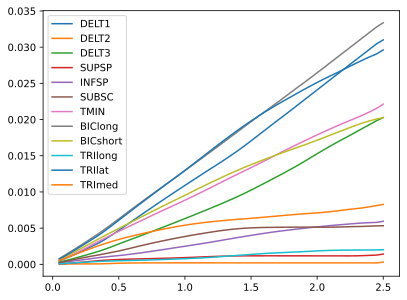

In [12]:
lifting_muscles = ["DELT1", "DELT2", "DELT3", "SUPSP", "INFSP", "SUBSC", "TMIN", "BIClong", "BICshort", "TRIlong", "TRIlat", "TRImed"]  #muscles of the mobl_arms_wrist that act on the shoulder
lifting_indices = [env._model.actuator(_i).id for _i in lifting_muscles]

_logdata = eval_logs.get_logs("3CCr_MF", indices=lifting_indices)

plt.plot(_logdata.keys(), _logdata.values(), label=lifting_muscles)
plt.legend()

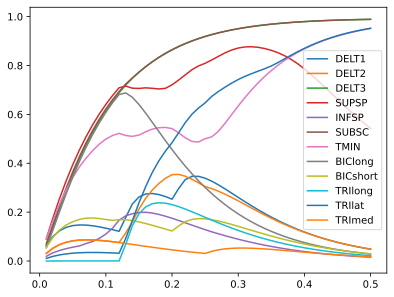

In [172]:
lifting_muscles = ["DELT1", "DELT2", "DELT3", "SUPSP", "INFSP", "SUBSC", "TMIN", "BIClong", "BICshort", "TRIlong", "TRIlat", "TRImed"]  #muscles of the mobl_arms_wrist that act on the shoulder
lifting_indices = [env._model.actuator(_i).id for _i in lifting_muscles]

_logdata = eval_logs.get_logs("3CCr_MA", indices=lifting_indices)

plt.plot(_logdata.keys(), _logdata.values(), label=lifting_muscles)
plt.legend()

In [22]:
#display_video([(np.concatenate((np.moveaxis(i["vision"], 0, 2), 0*np.ones((80, 120, 1))), axis=-1)[..., [0, 2, 1]]/2 + 0.5) for i in obs_collection], framerate=100)
display_video([i["unity_image"] for i in info_collection], framerate=100)


## Run Evaluations

In [11]:
## EVALUATE LIST OF SIMULATION DIRS

import uitb
os.chdir(uitb.__path__[0])
os.chdir("..")

SIMULATION_DIRS = [
    "simulators/unity_low_difficulty_easy_3ccr_1e3",  #low-easy
    "simulators/unity_difficulty_easy_3ccr_1e3",  #mid-easy
    "simulators/unity_high_difficulty_easy_3ccr_1e3",  #high-easy
    # "simulators/unity_low_difficulty_easy_ce",  #low-easy
    # "simulators/unity_difficulty_easy_ce",  #mid-easy
    # "simulators/unity_high_difficulty_easy_ce",  #high-easy
    # "trained/unity_easy/",
    # "trained/unity_medium_pretrained/",
    # "trained/unity_hard_pretrained/",
    # "trained/unity_low_pretrained/",
    # "trained/unity_medium_pretrained/",  #mid-medium
    # "trained/unity_high_pretrained/",
    ]

_SIMULATION_USER_ID = 901  #fake simulation user ID used for testing

for _TASK_CONDITION in SIMULATION_DIRS:
    print(f"\n\nTASK CONDITION: {_TASK_CONDITION}\n")
    os.environ["_TASK_CONDITION"] = _TASK_CONDITION

    %run uitb/test/evaluator.py $_TASK_CONDITION --num_episodes 1 --record --logging

    _copy_to_dataset(TASK_CONDITION=_TASK_CONDITION, SIMULATION_USER_ID=_SIMULATION_USER_ID)



TASK CONDITION: simulators/unity_low_difficulty_easy_3ccr_1e3

Attempting to connect to Unity app
[UnityMemory] Configuration Parameters - Can be set up in boot.config
    "memorysetup-bucket-allocator-granularity=16"
    "memorysetup-bucket-allocator-bucket-count=8"
    "memorysetup-bucket-allocator-block-size=4194304"
    "memorysetup-bucket-allocator-block-count=1"
    "memorysetup-main-allocator-block-size=16777216"
    "memorysetup-thread-allocator-block-size=16777216"
    "memorysetup-gfx-main-allocator-block-size=16777216"
    "memorysetup-gfx-thread-allocator-block-size=16777216"
    "memorysetup-cache-allocator-block-size=4194304"
    "memorysetup-typetree-allocator-block-size=2097152"
    "memorysetup-profiler-bucket-allocator-granularity=16"
    "memorysetup-profiler-bucket-allocator-bucket-count=8"
    "memorysetup-profiler-bucket-allocator-block-size=4194304"
    "memorysetup-profiler-bucket-allocator-block-count=1"
    "memorysetup-profiler-allocator-block-size=16777216

In [17]:
import uitb
os.chdir(uitb.__path__[0])
os.chdir("..")

_TASK_CONDITION = "trained/unity_high_pretrained"  #OPTIONS: "trained/unity_easy", "trained/unity_medium_pretrained", "trained/unity_hard_pretrained", "trained/unity_low_pretrained", "trained/unity_high_pretrained"
_TASK_CONDITION = "simulators/test_unity_difficulty_easy_3ccr"

_TASK_CONDITION = "simulators/unity_high_difficulty_easy_3ccr"

os.environ["_TASK_CONDITION"] = _TASK_CONDITION
# %run uitb/test/evaluator.py $_TASK_CONDITION --num_episodes 1 --record --logging
%run uitb/test/evaluator.py $_TASK_CONDITION --num_episodes 10 --logging

Attempting to connect to Unity app
[UnityMemory] Configuration Parameters - Can be set up in boot.config
    "memorysetup-bucket-allocator-granularity=16"
    "memorysetup-bucket-allocator-bucket-count=8"
    "memorysetup-bucket-allocator-block-size=4194304"
    "memorysetup-bucket-allocator-block-count=1"
    "memorysetup-main-allocator-block-size=16777216"
    "memorysetup-thread-allocator-block-size=16777216"
    "memorysetup-gfx-main-allocator-block-size=16777216"
    "memorysetup-gfx-thread-allocator-block-size=16777216"
    "memorysetup-cache-allocator-block-size=4194304"
    "memorysetup-typetree-allocator-block-size=2097152"
    "memorysetup-profiler-bucket-allocator-granularity=16"
    "memorysetup-profiler-bucket-allocator-bucket-count=8"
    "memorysetup-profiler-bucket-allocator-block-size=4194304"
    "memorysetup-profiler-bucket-allocator-block-count=1"
    "memorysetup-profiler-allocator-block-size=16777216"
    "memorysetup-profiler-editor-allocator-block-size=1048576"


Copy evaluation logs (including pickle files) to dataset directory

In [15]:
_SIMULATION_USER_ID = 91  #fake simulation user ID used for testing
_copy_to_dataset(TASK_CONDITION=_TASK_CONDITION, SIMULATION_USER_ID=_SIMULATION_USER_ID)

In [100]:
_rng = np.random.default_rng()
strength = _rng.uniform(0, 1, size=32)

In [113]:
# if strength > 0.15:
#     endurance = (1236.5/((strength*100 - 15)**0.618)) - 72.5
# else:
#     endurance = np.inf
endurance = np.inf * np.ones_like(strength)
endurance[strength > 0.15] = (1236.5/((strength[strength > 0.15]*100 - 15)**0.618)) - 72.5
0.02/np.min(endurance)*100, 0.02/endurance*100

np.mean(endurance[endurance<np.inf]), (1236.5/((np.mean(strength)*100 - 15)**0.618)) - 72.5

(54.65900717814575, 41.21152488297393)

**NOTES on simulation user IDs:**
- 99: testing
- 91: Aleksi's trained models evaluated with 3CCr costs
- 92: Aleksi's trained models evaluated with CE costs
- 901: trained with 3CCr costs (cost weight: 1e-3)
- 902: trained with CE costs

**Evaluate fatigue/effort metrics for different conditions.**

In [52]:
lifting_muscles = ["DELT1", "DELT2", "DELT3", "SUPSP", "INFSP", "SUBSC", "TMIN", "BIClong", "BICshort", "TRIlong", "TRIlat", "TRImed"]  #muscles of the mobl_arms_wrist that act on the shoulder
lifting_indices = [0, 1, 2, 3, 4, 5, 6, 20, 21, 15, 16, 17]  #[env._model.actuator(_i).id for _i in lifting_muscles]

In [78]:
_test = np.load("/home/florian/uitb-sim2vr/user-in-the-box-private/datasets/vr-uitb-experiment/91/09-22-59-low/state_log.pickle", allow_pickle=True)
np.mean([np.mean(i["effort_cost"][1:]) for i in _test.values()])
np.mean([np.mean(list(map(np.mean, i["3CCr_MF"]))) for i in _test.values()])
np.mean([np.mean(list(map(lambda x: np.mean(x[lifting_indices]), i["3CCr_MF"]))) for i in _test.values()])

0.009041414504301716

In [79]:
_test = np.load("/home/florian/uitb-sim2vr/user-in-the-box-private/datasets/vr-uitb-experiment/91/09-25-50-mid/state_log.pickle", allow_pickle=True)
_test["episode_00"]["effort_cost"]
np.mean([np.mean(i["effort_cost"][1:]) for i in _test.values()])
np.mean([np.mean(list(map(np.mean, i["3CCr_MF"]))) for i in _test.values()])
np.mean([np.mean(list(map(lambda x: np.mean(x[lifting_indices]), i["3CCr_MF"]))) for i in _test.values()])

0.012098482248632997

In [80]:
_test = np.load("/home/florian/uitb-sim2vr/user-in-the-box-private/datasets/vr-uitb-experiment/91/09-29-58-high/state_log.pickle", allow_pickle=True)
_test["episode_00"]["effort_cost"]
np.mean([np.mean(i["effort_cost"][1:]) for i in _test.values()])
np.mean([np.mean(list(map(np.mean, i["3CCr_MF"]))) for i in _test.values()])
np.mean([np.mean(list(map(lambda x: np.mean(x[lifting_indices]), i["3CCr_MF"]))) for i in _test.values()])

0.011319434036023542

## Run Training

Run from command line with X11 (e.g., using MobaXterm):
```python
export DISPLAY=:1
python uitb/train/trainer.py uitb/configs/mobl_arms_unity_test1.yaml
```

## Utils

Copy build files (i.e., a standalone Unity app for each task condition/target setup) to source dir.

In [89]:
for _cond in ["unity_easy", "unity_medium_pretrained", "unity_hard_pretrained", "unity_low_pretrained", "unity_high_pretrained"]:
    os.popen(f"mkdir ~/uitb-sim2vr/user-in-the-box-private/uitb/tasks/unity/build/{_cond.split('_')[1]}")
    os.popen(f"cp ~/uitb-sim2vr/user-in-the-box-private/trained/{_cond}/{_cond}/tasks/unity/build/build.x86_64 ~/uitb-sim2vr/user-in-the-box-private/uitb/tasks/unity/build/{_cond.split('_')[1]}/build.x86_64")
    os.popen(f"cp ~/uitb-sim2vr/user-in-the-box-private/trained/{_cond}/{_cond}/tasks/unity/build/UnityPlayer.so ~/uitb-sim2vr/user-in-the-box-private/uitb/tasks/unity/build/{_cond.split('_')[1]}/UnityPlayer.so")
    os.popen(f"cp ~/uitb-sim2vr/user-in-the-box-private/trained/{_cond}/{_cond}/tasks/unity/build/build_Data ~/uitb-sim2vr/user-in-the-box-private/uitb/tasks/unity/build/{_cond.split('_')[1]}/ -r")

mkdir: cannot create directory ‘/home/florian/uitb-sim2vr/user-in-the-box-private/uitb/tasks/unity/build/low’: File exists
mkdir: cannot create directory ‘/home/florian/uitb-sim2vr/user-in-the-box-private/uitb/tasks/unity/build/high’: File exists
